In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [2]:
import urllib  # the lib that handles the url stuff

data = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names') # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

b'1. Title: Auto-Mpg Data\n'
b'\n'
b'2. Sources:\n'
b'   (a) Origin:  This dataset was taken from the StatLib library which is\n'
b'                maintained at Carnegie Mellon University. The dataset was \n'
b'                used in the 1983 American Statistical Association Exposition.\n'
b'   (c) Date: July 7, 1993\n'
b'\n'
b'3. Past Usage:\n'
b'    -  See 2b (above)\n'
b'    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.\n'
b'       In Proceedings on the Tenth International Conference of Machine \n'
b'       Learning, 236-243, University of Massachusetts, Amherst. Morgan\n'
b'       Kaufmann.\n'
b'\n'
b'4. Relevant Information:\n'
b'\n'
b'   This dataset is a slightly modified version of the dataset provided in\n'
b'   the StatLib library.  In line with the use by Ross Quinlan (1993) in\n'
b'   predicting the attribute "mpg", 8 of the original instances were removed \n'
b'   because they had unknown values for the "mpg" attribute.  The original \n'
b'   d

In [3]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, names=column_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Data cleaning

In [4]:
df = df.replace('?', np.nan)
df = df.dropna()
df['horsepower'] = df['horsepower'].astype(float)
#df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Data visualisation

In [5]:
independant_var = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

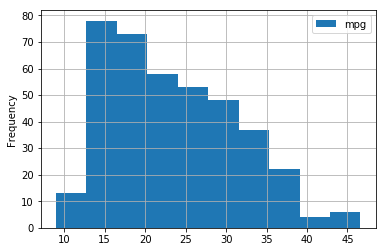

In [6]:
df.plot(kind='hist', y='mpg', grid=True)

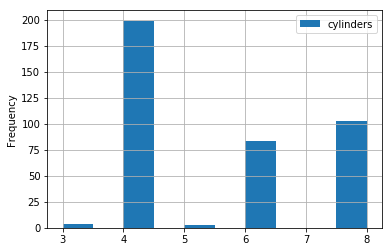

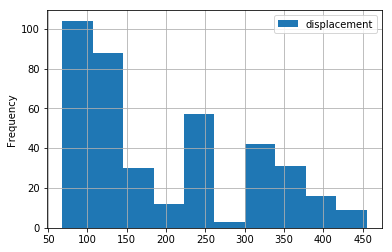

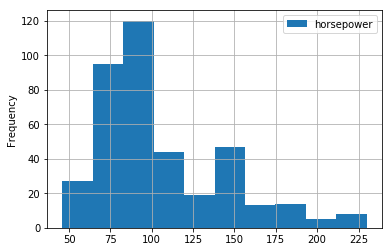

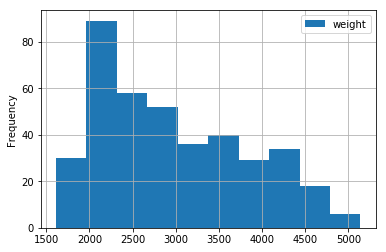

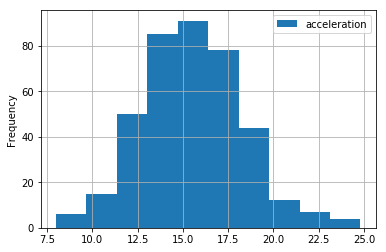

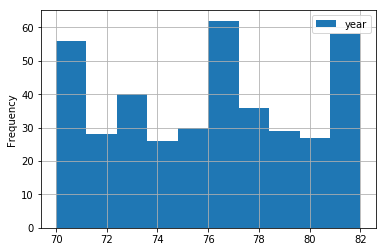

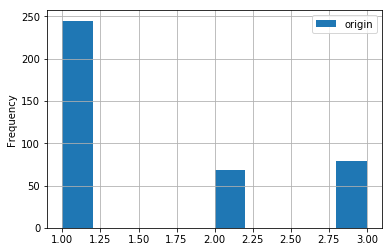

In [7]:
for param in independant_var:
    try:
        df.plot(kind='hist', y=param, grid=True)
    except:
        df[param].value_counts().plot(kind='bar', grid=True)

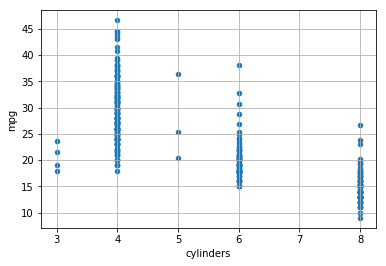

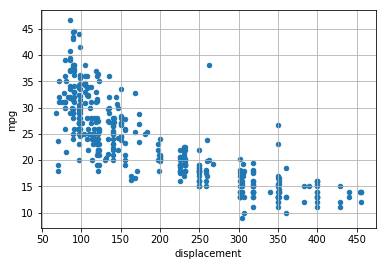

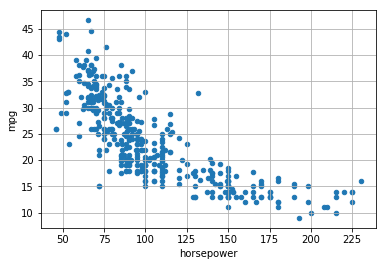

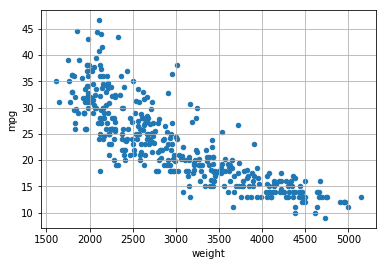

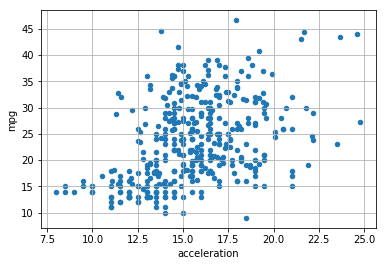

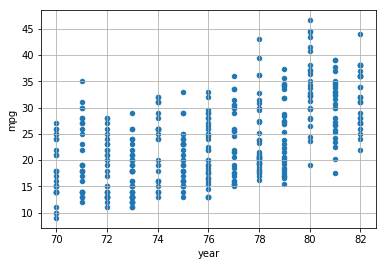

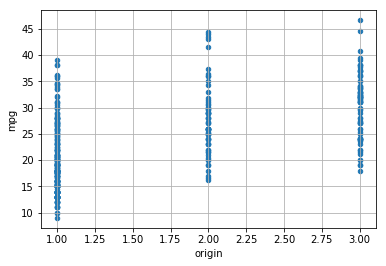

In [8]:
for param in independant_var:
    df.plot(kind='scatter', x=param, y='mpg', grid=True)

# Model
Aim is to model mpg (miles per gallon) from information contained in the dataset

# Tensorflow with lattice

In [9]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_lattice as tfl

print(tf.__version__)

2.2.0


In [10]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [11]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 100

In [12]:
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']
features = df[main_independant_var].values
target = df['mpg']

In [13]:
# Lattice layer expects input[i] to be within [0, lattice_sizes[i] - 1.0], so
lattice_sizes = [3, 5, 5, 3, 5, 3, 2]

In [14]:
wrinkle_regularizer = 1e0

combined_calibrators = tfl.layers.ParallelCombination(autocast=False)

# ############### cylinders ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(df['cylinders'].min(), df['cylinders'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
    monotonicity='decreasing',
    kernel_regularizer=('wrinkle', 0, wrinkle_regularizer),
)
combined_calibrators.append(calibrator)

# ############### displacement ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(df['displacement'].min(), df['displacement'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[1] - 1.0,
    monotonicity='decreasing',
    kernel_regularizer=('wrinkle', 0, wrinkle_regularizer),
    #convexity='concave'
)
combined_calibrators.append(calibrator)

# ############### weight ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(df['weight'].min(), df['weight'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[2] - 1.0,
    monotonicity='decreasing',
    kernel_regularizer=('wrinkle', 0, wrinkle_regularizer),
)
combined_calibrators.append(calibrator)

# ############### year ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(df['year'].min(), df['year'].max(), num=2),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[3] - 1.0,
    monotonicity='increasing',
    kernel_regularizer=('wrinkle', 0, wrinkle_regularizer),
)
combined_calibrators.append(calibrator)

# ############### horsepower ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(0,
                                df['horsepower'].max() + 2 * df['horsepower'].std(),
                                num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[4] - 1.0,
    monotonicity='decreasing',
    kernel_regularizer=('wrinkle', 0, wrinkle_regularizer),
)
combined_calibrators.append(calibrator)

# ############### acceleration ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(df['acceleration'].min(), df['acceleration'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[5] - 1.0,
    monotonicity='none',
)
combined_calibrators.append(calibrator)

# ############### origin ###############
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=3,
    output_min=0.0,
    output_max=lattice_sizes[6] - 1.0,
    kernel_initializer='constant')
combined_calibrators.append(calibrator)

In [15]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing', 'increasing', 'increasing', 'increasing', 'increasing', None, None
    ],
    output_min=target.min(),
    output_max=target.max())

In [16]:
model = tf.keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)

In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epoch_dots = tfdocs.modeling.EpochDots(report_every=10, dot_every=1)

In [18]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),  # Optimizer
    # Loss function to minimize
    loss='mse',
    # List of metrics to monitor
    metrics=['mse', 'mae'],
)

In [19]:
history = model.fit(
    features,
    target,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    shuffle=False,
    verbose=0,
    callbacks=[early_stopping, epoch_dots])


Epoch: 0, loss:31.6707,  mae:4.6622,  mse:31.5498,  val_loss:24.0963,  val_mae:3.8819,  val_mse:23.9623,  
..........
Epoch: 10, loss:6.6447,  mae:1.8617,  mse:6.4798,  val_loss:21.5451,  val_mae:3.4263,  val_mse:21.3447,  
..........
Epoch: 20, loss:13.1540,  mae:2.9120,  mse:13.0642,  val_loss:34.7723,  val_mae:4.5369,  val_mse:34.4376,  
..........
Epoch: 30, loss:5.5826,  mae:1.7484,  mse:5.5066,  val_loss:22.4532,  val_mae:3.5025,  val_mse:22.4263,  
..........
Epoch: 40, loss:5.2692,  mae:1.7097,  mse:5.1885,  val_loss:22.1027,  val_mae:3.3815,  val_mse:21.8908,  
..........
Epoch: 50, loss:5.2507,  mae:1.7069,  mse:5.0575,  val_loss:27.8674,  val_mae:3.9193,  val_mse:27.7029,  
..........
Epoch: 60, loss:4.8946,  mae:1.6631,  mse:4.7846,  val_loss:26.0583,  val_mae:3.6868,  val_mse:25.8311,  
........

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parallel_combination (Parall multiple                  30        
_________________________________________________________________
lattice (Lattice)            multiple                  6750      
Total params: 6,780
Trainable params: 6,780
Non-trainable params: 0
_________________________________________________________________


(0, 20)

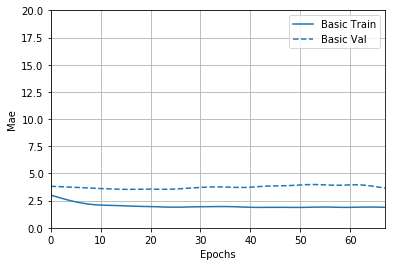

In [21]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 20])

In [22]:
df['MPG_pred'] = model.predict(df[main_independant_var])
df['MPG_error'] = df['MPG_pred'] - df['mpg']

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
print(
    'scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(df['MPG_pred'], df['mpg']),
           r2_score(df['MPG_pred'], df['mpg'])
          )
)

scores
mse=7.89
r2=0.85



/Users/thomas/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


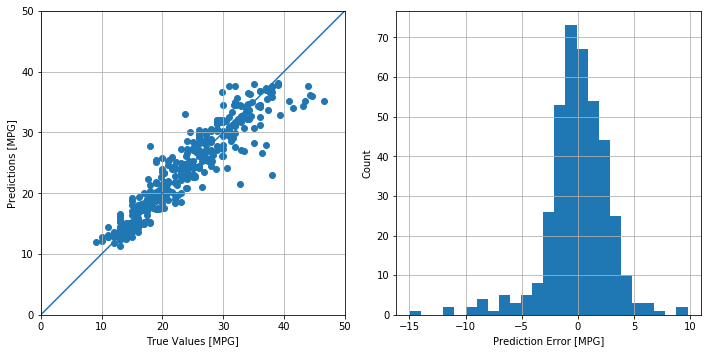

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(df['mpg'], df['MPG_pred'])
ax[0].set_xlabel('True Values [MPG]')
ax[0].set_ylabel('Predictions [MPG]')
lims = [0, 50]
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].plot(lims, lims)
ax[0].set_aspect('equal')
ax[0].grid('on')

ax[1].hist(df['MPG_error'], bins = 25)
ax[1].set_xlabel("Prediction Error [MPG]")
ax[1].set_ylabel("Count")
#ax[1].set_aspect('equal')
ax[1].grid('on')

plt.tight_layout()

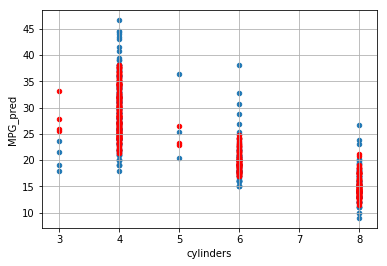

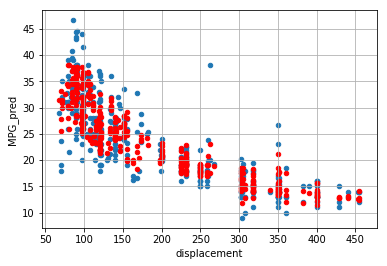

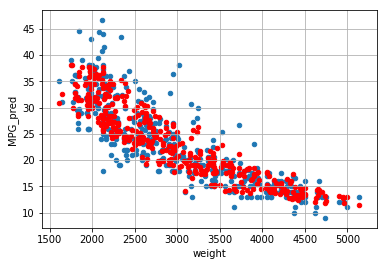

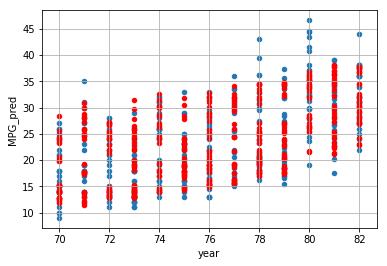

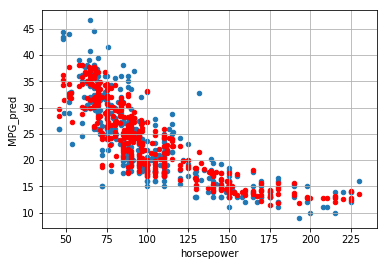

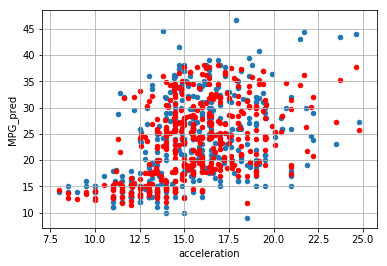

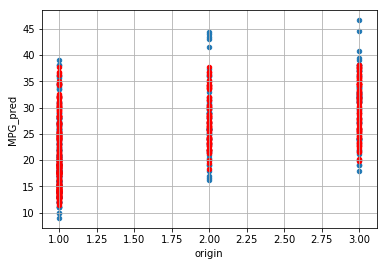

In [25]:
for param in main_independant_var:
    ax = df.plot(kind='scatter', x=param, y='mpg', grid=True)
    df.plot(kind='scatter', x=param, y='MPG_pred', grid=True, ax=ax, c='r')

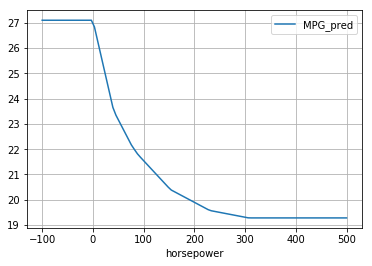

In [26]:
df_tmp = pd.DataFrame()
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']


df_tmp['cylinders'] = [8]*100#np.linspace(0, 10, 100)#
df_tmp['displacement'] = 200#np.linspace(0, 500, 100)#200
df_tmp['weight'] = 3000#np.linspace(0, 10000, 100)#[5000]*100
df_tmp['year'] = 75#[70, 80]*50
df_tmp['horsepower'] = np.linspace(-100, 500, 100)
df_tmp['acceleration'] = 20#np.linspace(0, 30, 100)#20
df_tmp['origin'] = 0

df_tmp['MPG_pred'] = model.predict(df_tmp[main_independant_var])

ax = df_tmp.plot(kind='line', x='horsepower', y='MPG_pred', grid=True)